EPSG:25832

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 183 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
GeoJSON file saved as: Germany_postal_codes.geojson


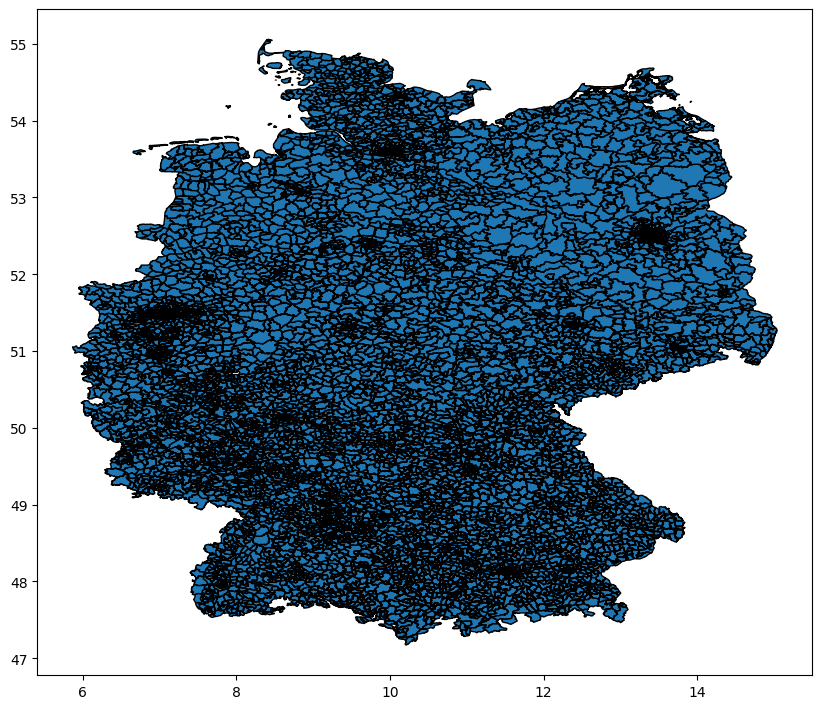

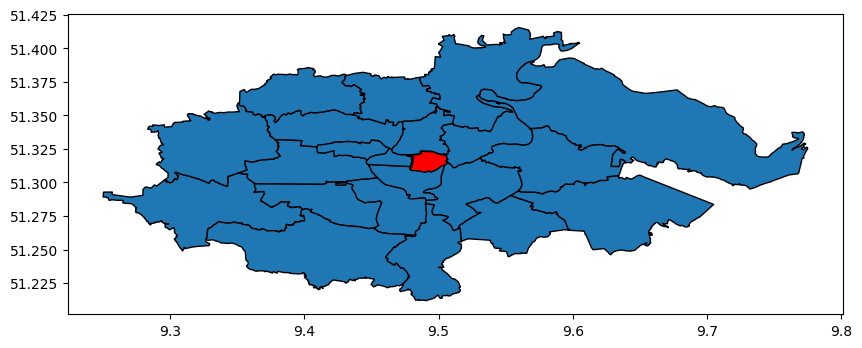

In [2]:
# Importing necessary libraries
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import geojson

# Function to handle MultiPolygon geometries
def handle_multipolygon(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        polygons = [Polygon(list(poly.exterior.coords)) for poly in multipolygon.geoms]
        return polygons
    elif isinstance(multipolygon, Polygon):
        return [multipolygon]
    else:
        print(f"Unhandled geometry type: {type(multipolygon)}")
        return []

# Function to extract postal code polygons and optionally save as GeoJSON
def postal_code_polygon_dict_extractor(place_name, save_geojson=False):
    postal_code_polygons = ox.features_from_place(place_name, tags={"boundary": "postal_code"})

    # Create GeoDataFrame and drop rows with missing postal_code or geometry
    gdf = gpd.GeoDataFrame(postal_code_polygons).dropna(subset=['postal_code', 'geometry'])

    postal_code_polygon_dict = {}

    # Iterate through GeoDataFrame rows to create a dictionary
    for _, feature in gdf.iterrows():
        postal_code = feature['postal_code']
        geometry = feature['geometry']

        geometries = handle_multipolygon(geometry)

        postal_code_polygon_dict[postal_code] = geometries

    # Optionally save GeoJSON
    if save_geojson:
        geojson_filename = f"{place_name}_postal_codes.geojson"
        geojson_features = []

        for postal_code, geometries_list in postal_code_polygon_dict.items():
            for geometry in geometries_list:
                coordinates = list(geometry.exterior.coords)

                feature = {
                    "postal_code": postal_code,
                    "geometry": {
                        "type": geometry.geom_type,
                        "coordinates": coordinates
                    }
                }

                geojson_features.append(feature)

        with open(geojson_filename, 'w') as file:
            geojson.dump(geojson_features, file)

        print(f"GeoJSON file saved as: {geojson_filename}")

    return postal_code_polygon_dict

# Function to plot postal code polygons with optional highlighting and zooming
def plot_all_postal_code_polygons(gdf, highlight_postal_code=None, zoom_into_city=False):
    crs = "EPSG:25832"

    if zoom_into_city:
        # Get the bounding box of the GeoDataFrame
        bbox = gdf.total_bounds
        margin = 0.1  # 10% margin
        bbox_expanded = [bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin]
        gdf = gdf.cx[bbox_expanded[0]:bbox_expanded[2], bbox_expanded[1]:bbox_expanded[3]]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Set the CRS for the GeoDataFrame
    gdf.crs = crs

    # Plot the map with the GeoDataFrame and apply the specified projection
    gdf.to_crs(crs).plot(ax=ax, edgecolor='k')

    if highlight_postal_code is not None:
        highlight_geometry = gdf[gdf['postal_code'] == highlight_postal_code].to_crs(crs)
        highlight_geometry.plot(color='red', edgecolor='black', ax=ax)

    # Display the map
    plt.show()

# Example usage for Germany with saving GeoJSON data, using EPSG:25832,
# and optionally zooming into Kassel and highlighting a postal code
place_postal_code_polygons_germany = postal_code_polygon_dict_extractor("Germany", save_geojson=True)
highlight_postal_code_germany = "34117"
gdf_germany = gpd.GeoDataFrame(geometry=[geometry for geometries in place_postal_code_polygons_germany.values() for geometry in geometries])
gdf_germany['postal_code'] = [postal_code for postal_code in place_postal_code_polygons_germany.keys() for _ in place_postal_code_polygons_germany[postal_code]]
zoom_into_city = True
highlight_postal_code_kassel = "34117"

# Plot Germany map with highlighted postal code
plot_all_postal_code_polygons(gdf_germany, highlight_postal_code=highlight_postal_code_germany, zoom_into_city=zoom_into_city)

# Optionally, you can zoom into Kassel and highlight a postal code
if zoom_into_city:
    place_postal_code_polygons_kassel = postal_code_polygon_dict_extractor("Kassel")
    gdf_kassel = gpd.GeoDataFrame(geometry=[geometry for geometries in place_postal_code_polygons_kassel.values() for geometry in geometries])
    gdf_kassel['postal_code'] = [postal_code for postal_code in place_postal_code_polygons_kassel.keys() for _ in place_postal_code_polygons_kassel[postal_code]]

    # Plot Kassel map with highlighted postal code
    plot_all_postal_code_polygons(gdf_kassel, highlight_postal_code=highlight_postal_code_kassel)
